# Explaining models using LIME

This code will find the areas that encourage the top prediction of a model, as well as the areas that go against it. This is done by using LIME (Local Interpretable Model-agnostic Explanations) to explain the model's predictions.

### Importing dependencies

In [2]:
import os
import numpy as np
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Resize

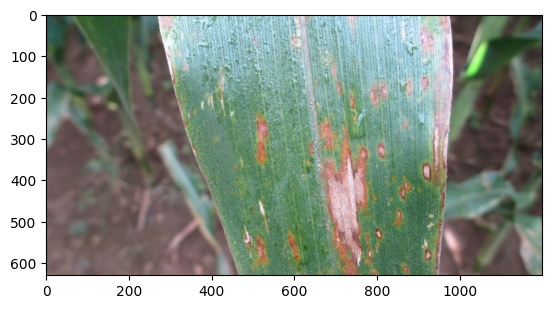

In [66]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_image('/content/Corn_Gray_Spot (9).jpg')
plt.imshow(img)

In [45]:
means = [0.43766510486602783, 0.49804747104644775, 0.3756938874721527]
stds = [0.16779577732086182, 0.1552586406469345, 0.1632111817598343]
def get_input_transform():
    normalize = Normalize(mean=means, std=stds)
    transf = Compose([
        Resize((64, 64)),
        ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)


# import model from ./saved_models/simplenn.pth
import torch.nn as nn
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(3136, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 4) # output to 4 classes

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model = SimpleNN()
checkpoint = torch.load('/content/simplenn.pth')
model.load_state_dict(checkpoint["state_dict"])
model.eval()
img_t = get_input_tensors(img)
logits = model(img_t)
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(4)
print(probs5)

torch.return_types.topk(
values=tensor([[9.9720e-01, 2.5684e-03, 2.2592e-04, 1.9106e-06]],
       grad_fn=<TopkBackward0>),
indices=tensor([[0, 2, 1, 3]]))


In [67]:
def get_pil_transform():
    transf = Compose([
        Resize((64, 64))
    ])

    return transf

def get_preprocess_transform():
    normalize = Normalize(mean=means, std=stds)
    transf = Compose([
        ToTensor(),
        normalize
    ])
    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


test_pred = batch_predict([pill_transf(img)])
labels = ["Blight", "Gray Leaf Spot", "Common Rust", "Healthy"]
print(labels[test_pred.squeeze().argmax()])

0

  0%|          | 0/1000 [00:00<?, ?it/s]

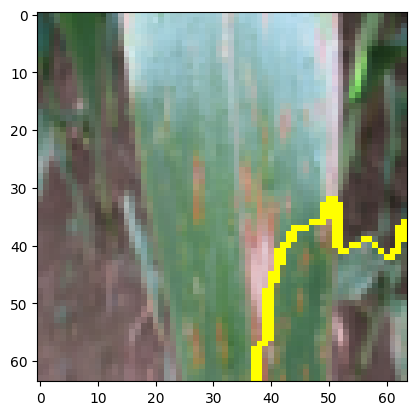

In [68]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

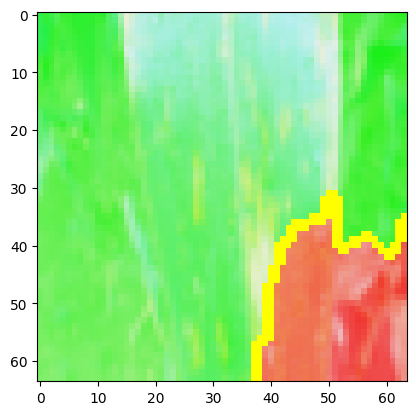

In [69]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)